In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import json
import os
from scipy.stats import linregress

from peaks.load_NIST import load_NIST_data
from scipy.signal import find_peaks
from plots.aniplot import load_data, load_shot
from peaks.check import multimax, compare_peaks_with_nist
from plots.plot import plot_max_spectra

In [48]:

path_spectrometer = '/home/jessalsua/DAQ'
path_shots = os.path.join(path_spectrometer, 'Shots')
# Compare the peak wavelengths with NIST data
nist_file_path = os.path.join(path_spectrometer,'OOSpec_Control', 'peaks','ArNIST.txt')  # Adjust path as needed
ebs_file_path = os.path.join(path_spectrometer, 'OOSpec_Control', 'peaks', 'ArEBS_Air.txt')  # Adjust path as needed
N_file_path = os.path.join(path_spectrometer, 'OOSpec_Control', 'peaks', 'NNIST.txt')  # Adjust path as needed
O_file_path = os.path.join(path_spectrometer, 'OOSpec_Control', 'peaks', 'ONIST.txt')  # Adjust path as needed
C_file_path = os.path.join(path_spectrometer, 'OOSpec_Control', 'peaks', 'CNIST.txt')  # Adjust path as needed

line_files = [
    nist_file_path,
    ebs_file_path,
    N_file_path,
    O_file_path,
    C_file_path
]

colors = {
        'Ar I': 'blue',
    }

shot_number = '000110'


Analyzing peaks for shot 0
Number of peaks found: 16
Peaks found at indices: [1105 1128 1200 1227 1256 1277 1328 1343 1366 1400 1433 1436 1459 1597
 1621 1722]
Peak wavelengths: [695.70892334 705.92297363 737.80639648 749.72692871 762.50866699
 771.75024414 794.14428711 800.71734619 810.78405762 825.63873291
 840.02618408 841.33258057 851.34051514 911.0791626  921.4140625
 964.72772217]
Peak counts: [ 3457.57788086  2816.2947998   4298.21350098 15843.57348633
 25221.59033203  6770.64916992  6583.94165039  9439.27197266
 68933.60351562  4372.85498047  7925.31787109 15346.42895508
  4069.12768555 13971.69970703  3093.03613281  2374.6328125 ]
Peak wavelength 695.71 nm is closest to NIST wavelength 696.54 nm (Ar I)
Peak wavelength 705.92 nm is closest to NIST wavelength 706.72 nm (Ar I)
Peak wavelength 737.81 nm is closest to NIST wavelength 738.04 nm (Ar II)
Peak wavelength 749.73 nm is closest to NIST wavelength 750.39 nm (Ar I)
Peak wavelength 762.51 nm is closest to NIST wavelength 763

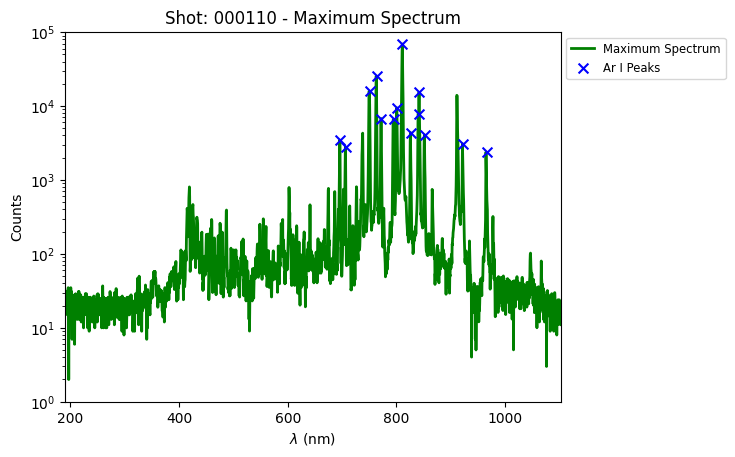

In [49]:
data_spec, max_spectra = plot_max_spectra(
    shot_number=shot_number,
    path_shots=path_shots,
    lines_files=line_files,
    spec=colors,
    ylim=[1e0, 1e5],
    min_peak=1e3,
)   

In [57]:
data_ArNIST = load_NIST_data(nist_file_path)

mask_ArNIST = np.array(data_ArNIST['Intensity']) > 100
wave_ArNIST = np.array(data_ArNIST['Wavelength'])[mask_ArNIST]

peak_index, _ = find_peaks(max_spectra['spectra'][0], height=1e3)
peak_wavelengths = max_spectra['wave'][0][peak_index]
peak_counts = max_spectra['spectra'][0][peak_index]


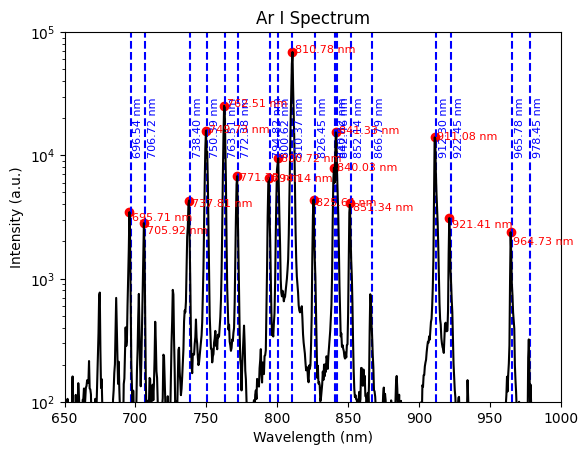

In [59]:
fig_spec, ax_spec = plt.subplots()
ax_spec.set_title('Ar I Spectrum')
ax_spec.set_xlabel('Wavelength (nm)')
ax_spec.set_ylabel('Intensity (a.u.)')
ax_spec.set_xscale('linear')
ax_spec.set_yscale('log')
ax_spec.set_xlim(650, 1000)
ax_spec.set_ylim(1e2, 1e5)
for i, wave in enumerate(wave_ArNIST):
    if wave*1e-1 < 650 or wave*1e-1 > 1000:
        continue
    if abs(wave - wave_ArNIST[i - 1]) < 15:
        continue
    ax_spec.axvline(wave*1e-1, color=colors['Ar I'], linestyle='--', label=f'Peak {i+1}: {wave:.2f} nm')
    ax_spec.text(wave*1e-1 + 2, 1e4, f'{wave*1e-1:.2f} nm', color=colors['Ar I'], fontsize=8, rotation=90)
ax_spec.plot(max_spectra['wave'][0], max_spectra['spectra'][0], label='Max Spectrum', color='black')
ax_scatter = ax_spec.scatter(peak_wavelengths, peak_counts, color='red', label='Detected Peaks')
for i, wave_peak in enumerate(peak_wavelengths):
    ax_spec.text(wave_peak + 2, peak_counts[i]  - 500, f'{wave_peak:.2f} nm', color='red', fontsize=8)
    
fig_spec.savefig(os.path.join(path_spectrometer, 'OOSpec_Control', 'peaks', f'Ar_Spectrum_{shot_number}_test.png'), dpi=300)

In [67]:

tab_energies = np.array([696.54, 706.72, 738.40, 750.39, 763.51, 772.98, 794.82, 800.62, 810.37, 826.45, 840.82, 842.46, 852.14, 912.30, 922.45, 965.78])
slope, intercept, r_value, p_value, std_err = linregress(peak_wavelengths, tab_energies)
print(f'Slope: {slope}, Intercept: {intercept}, R-squared: {r_value**2}')


Slope: 1.0014041334600354, Intercept: -0.38193349510584085, R-squared: 0.9999681365308254


In [ ]:
# Save cal data in json format
cal_data = {
    'slope': slope,
    'intercept': intercept,
    'r_squared': r_value**2,
    'peak_wavelengths': peak_wavelengths.tolist(),
    'tab_energies': tab_energies.tolist()
}
cal_file_path = os.path.join(path_spectrometer, 'OOSpec_Control', 'peaks', f'Cal_temp.json')
with open(cal_file_path, 'w') as f:
    json.dump(cal_data, f, indent=4)
